In [2]:
%pip install tensorflow imageio ai-edge-litert

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf
import numpy as np
import cv2
import imageio
from ai_edge_litert.interpreter import Interpreter

In [4]:
interpreter = Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
runner = interpreter.get_signature_runner()


In [5]:
# Initialize state tensors
init_states = {
    name: tf.zeros(info["shape"], dtype=info["dtype"])
    for name, info in runner.get_input_details().items()
}

# Remove image input (we'll provide it per frame)
init_states.pop("image")

states = init_states
print("Streaming states initialized")


Streaming states initialized


In [6]:
def to_gif(images,path = './animation.gif' ):
  converted_images = np.clip(images * 244, 0, 244).astype(np.uint8)
  imageio.mimsave(path, converted_images, fps=5)
  return embed.embed_file(path)


def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def video_to_gif_tensor(video_path, image_size=(224, 224), fps=12):
    """
    Processes frames from a video file, saves them as a GIF in the same directory, and loads the GIF as a TensorFlow tensor.

    Args:
      video_path: String path to the input video file.
      image_size: Tuple indicating the size to which each frame should be resized.
      fps: Frames per second to be used in the GIF.

    Returns:
      A TensorFlow tensor representing the loaded GIF.
    """
    # Generate the gif_path in the same directory with a .gif extension
    gif_path = os.path.splitext(video_path)[0] + '.gif'

    # Assume frames_from_video_file is a function that extracts frames from video
    images = frames_from_video_file(video_path, n_frames=fps)  # function to be defined or replaced

    # Convert images to uint8 and save as GIF
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)  # Proper scaling to 255
    imageio.mimsave(gif_path, converted_images, fps=fps)

    # Load the GIF file into a TensorFlow tensor
    raw = tf.io.read_file(gif_path)
    video = tf.io.decode_gif(raw)
    video = tf.image.resize(video, image_size)
    video = tf.cast(video, tf.float32) / 255.0  # Normalize to [0,1]

    return video

CLASSES = ['Fight','No_Fight']

def get_top_k(probs, k=2, label_map=CLASSES):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

video = video_to_gif_tensor('./assets/tf_X7GtOGyE_0.avi', image_size=(172, 172))
clips = tf.split(video[tf.newaxis], video.shape[0], axis=1)

states = init_states

all_probs = []  # shape: [num_frames, num_classes]

for clip in clips:
    outputs = runner(**states, image=clip)
    logits = outputs.pop('logits')[0]  # [num_classes]
    states = outputs

    probs = tf.nn.softmax(logits)
    all_probs.append(probs.numpy())

all_probs = tf.stack(all_probs).numpy()  # [T, C]


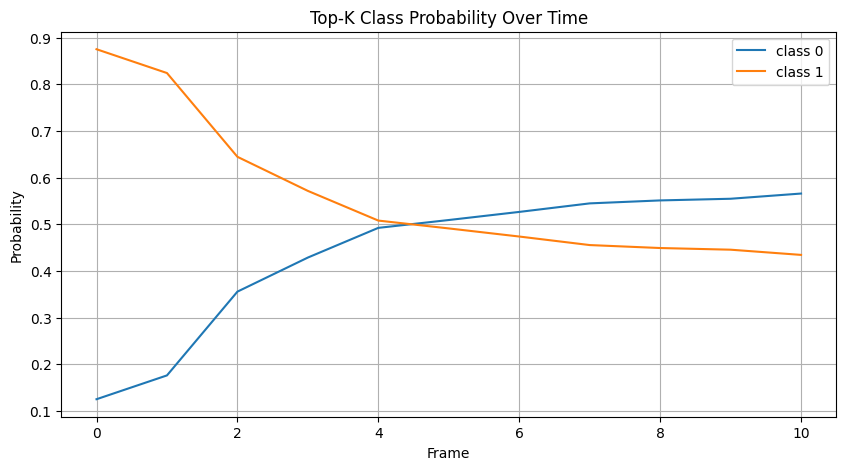

In [10]:
import numpy as np

k = 5
mean_probs = all_probs.mean(axis=0)
top_k_idx = np.argsort(mean_probs)[-k:]

plt.figure(figsize=(10, 5))

for idx in top_k_idx:
    plt.plot(all_probs[:, idx], label=f"class {idx}")

plt.xlabel("Frame")
plt.ylabel("Probability")
plt.title("Top-K Class Probability Over Time")
plt.legend()
plt.grid(True)
plt.show()
